# Time Series Forecast with Python

### Objective:

Based on how often the words 'mental health' have been googled worldwide in the past 5 years, how often will it likely be googled in the future? 

## 1. Import the Libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

from datetime import datetime, timedelta 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.stattools import kpss, adfuller

import warnings
warnings.filterwarnings('ignore')

## 2. Source the data 

In [2]:
df = pd.read_csv('multiTimeline.csv')

In [3]:
df.head()

,Category: All categories
Week,mental health: (Worldwide)
2016-07-17,29
2016-07-24,31
2016-07-31,31
2016-08-07,31


In [4]:
# number of columns is incorrect 

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 262 entries, Week to 2021-07-11
Data columns (total 1 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Category: All categories  262 non-null    object
dtypes: object(1)
memory usage: 4.1+ KB


In [6]:
df = pd.read_csv('multiTimeline.csv', skiprows = 1)
df.head()

,Week,mental health: (Worldwide)
0,2016-07-17,29
1,2016-07-24,31
2,2016-07-31,31
3,2016-08-07,31
4,2016-08-14,30


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Week                        261 non-null    object
 1   mental health: (Worldwide)  261 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.2+ KB


In [8]:
df.dtypes

Week                          object
mental health: (Worldwide)     int64
dtype: object

In [9]:
df['Week'] = pd.to_datetime(df['Week'])

In [10]:
df.dtypes

Week                          datetime64[ns]
mental health: (Worldwide)             int64
dtype: object

In [11]:
df.set_index('Week', inplace = True)

In [12]:
df.index

DatetimeIndex(['2016-07-17', '2016-07-24', '2016-07-31', '2016-08-07',
               '2016-08-14', '2016-08-21', '2016-08-28', '2016-09-04',
               '2016-09-11', '2016-09-18',
               ...
               '2021-05-09', '2021-05-16', '2021-05-23', '2021-05-30',
               '2021-06-06', '2021-06-13', '2021-06-20', '2021-06-27',
               '2021-07-04', '2021-07-11'],
              dtype='datetime64[ns]', name='Week', length=261, freq=None)

In [16]:
df['12-2019']

,mental health: (Worldwide)
Week,
2019-12-01,51
2019-12-08,47
2019-12-15,42
2019-12-22,28
2019-12-29,36


In [17]:
mh_ts = df['mental health: (Worldwide)']

In [18]:
mh_ts.head()

Week
2016-07-17    29
2016-07-24    31
2016-07-31    31
2016-08-07    31
2016-08-14    30
Name: mental health: (Worldwide), dtype: int64

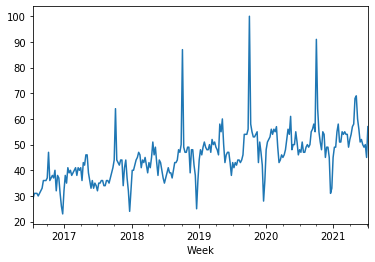

In [19]:
mh_ts.plot()

## 3. Data Analysis to find ARIMA (p, d, q) - parameters

#### Goal: try to recreate the mental health dataset 

#### 3.1 Decomposition

In [21]:
decomposition = seasonal_decompose(mh_ts, model = 'multiplicative', freq = 52)

# model can be chosen to be multiplicative or additive 

# In a multiplicative time series, the components multiply together to make the time series.
# If you have a increasing trend, the amplitude of seasonal activity increases 

# freq = the frequency of weeks - 52 weeks in a year

In [23]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

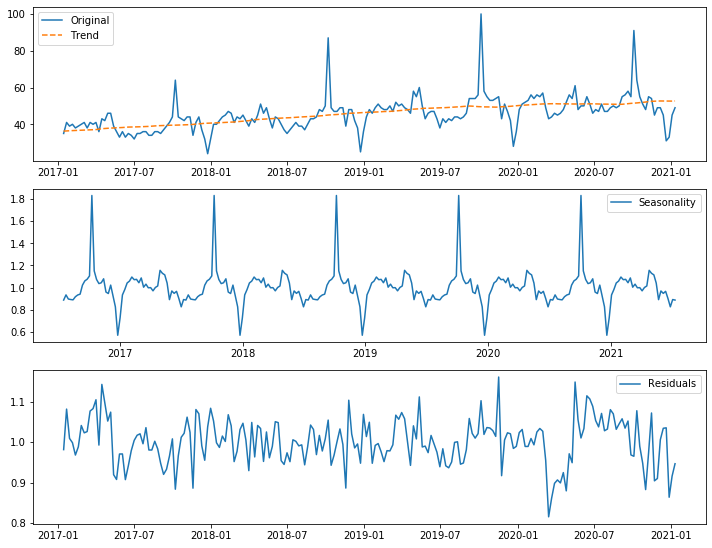

In [24]:
plt.figure(figsize = (10,10))

plt.figure(1)
plt.subplot(411)
plt.plot(trend*seasonal*residual, label = 'Original')
plt.plot(trend, label = 'Trend', linestyle = '--')
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

# residuals are the oscilations around the average 

#### 3.2 (Partial) Autocorrelation Function

we want to find the p- and the q- parameters from the ACF (autocorrelation function) and PACF (partial autocorrelation function)

ARIMA 

AR(p)

auto-regressice - I am predicting based on previous values 

I (intergrated) 

MA(q) 

moving average

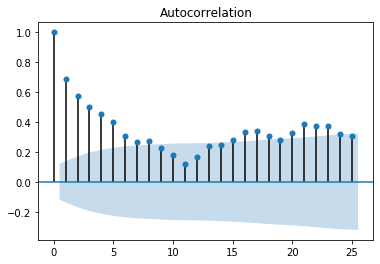

In [29]:
plot_acf(mh_ts)
plt.show()



#### 3.2.1 Test for Stationarity

- KPSS-Test: The null hypothesis is that the time series has no trend (stationary)
- ADF-Test: The null hypothesis is that the time series exhibits a trend (non-stationary)

In [30]:
kpss(mh_ts) # null hypothesis: trend is stationary

(1.4696213982612178,
 0.01,
 16,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

p-value = 0.01

as the p-value is less than 0.05, we regect the null hypothesis

In [31]:
adfuller(mh_ts)

(-1.7615826414539721,
 0.3996946435328357,
 15,
 245,
 {'1%': -3.4573260719088132,
  '5%': -2.873410402808354,
  '10%': -2.573095980841316},
 1638.1146891550002)

p-value = 0.4 

p-value is greater than 0.05, we accept the null hypothesis

these statistical ways to show that whether there is a trend or not

These tests are agreeing with each other

#### 3.3 Remove the trend: Differenciating

d = 1 -> first order differenciating

we need to make the data stationary, ie remove the trend

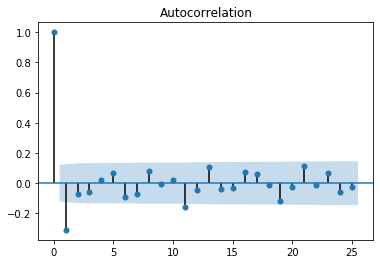

In [32]:
plot_acf(mh_ts.diff(1).dropna())
plt.show()

In [33]:
mh_ts_stationary = mh_ts.diff(1).dropna()
kpss(mh_ts_stationary)

# null hypothesis: trend-stationary (no trend)

(0.03872032258284947,
 0.1,
 16,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

p-value = 0.1

p-value is > 0.05 - we accept the null hypothesis

In [34]:
adfuller(mh_ts_stationary) # null hypothesis: non-stationary

(-7.896442433728168,
 4.298280001628217e-12,
 14,
 245,
 {'1%': -3.4573260719088132,
  '5%': -2.873410402808354,
  '10%': -2.573095980841316},
 1633.6333313153978)

p-value = 0.0000000000043

p-value < 0.05 - we reject the null hypothesis

we can conclude that we removed the trend making the time series stationary after differenciating once (d = 1)

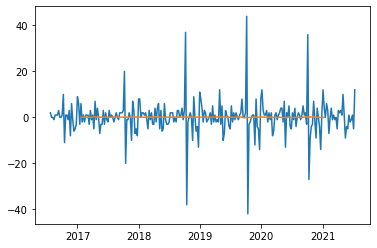

In [35]:
decomposition_stationary = seasonal_decompose(mh_ts_stationary)

plt.plot(mh_ts_stationary)
plt.plot(decomposition_stationary.trend)

q parameter: which time lags have significant correlation after removing the trend. 
    
based on the Differneciated ACF plot, q can take the values of 1 and 11 

q = 1 (lag = q)

#### Partial autocorrelation function

p = lag of the PACF

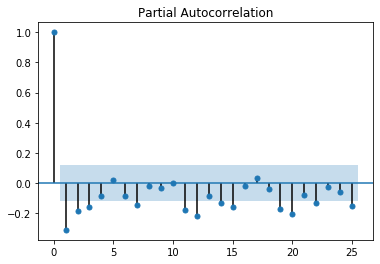

In [36]:
plot_pacf(mh_ts.diff(1).dropna())
plt.show()

p = 3 -> (lag = 3)

ARIMA(p, d, q) -> ARIMA(3, 1, 1)

## 4. Building the Model

In [37]:
mh_ts.head()

Week
2016-07-17    29
2016-07-24    31
2016-07-31    31
2016-08-07    31
2016-08-14    30
Name: mental health: (Worldwide), dtype: int64

In [38]:
mh_ts.tail()

Week
2021-06-13    50
2021-06-20    49
2021-06-27    50
2021-07-04    45
2021-07-11    57
Name: mental health: (Worldwide), dtype: int64

In [39]:
# train / test split

train = mh_ts[: '2019'].dropna()

test = mh_ts['2020' :].dropna()

if there was no seasonal component 

model = ARIMA(train, order = (3,1,1), enforce_stationary = False, enforce_invertibility = False)

becasue we do have a seasonal component, we need to use the SARIMA - the S stands for seasonal 

#### build the SARIMA(p,d,q)x(P,D,Q)[s] Model

use the ACF to obtain the upper limit for q/Q

use the PACF to obtain the upper limit for p/P

if the seasonality seems to be alternatively slowly decaying - P = 0 

time series model SARIMA(3,1,1)x(0,1,1)[52]

In [40]:
# seasonal ARIMA 

model = SARIMAX(train, order = (3,1,1), seasonal_order = (0,1,1,52), enforce_stationarity = False, enforce_invertability = False)

In [41]:
results = model.fit()

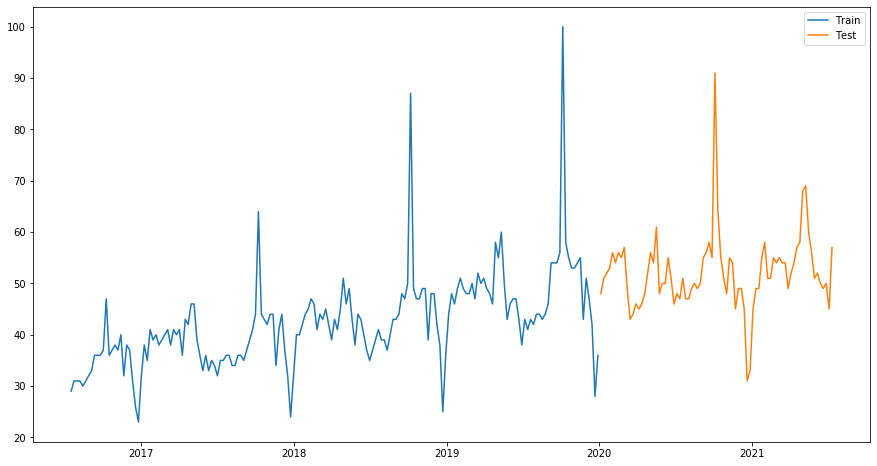

In [42]:
plt.figure(figsize = (15,8))
plt.plot(train, label = 'Train')   # from here, this is what we used to train our model 
plt.plot(test, label = 'Test')
plt.legend(loc = 'best')
plt.show()

In [43]:
pred = results.predict(start = '2020', end = '2021-07')

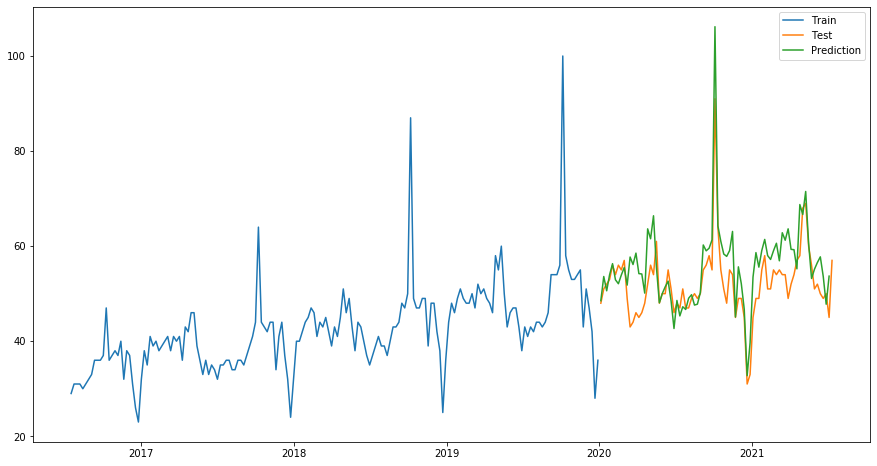

In [44]:
plt.figure(figsize = (15,8))
plt.plot(train, label = 'Train')    
plt.plot(test, label = 'Test')
plt.plot(pred, label = 'Prediction')
plt.legend(loc = 'best')
plt.show()

In [45]:
pred = results.predict(start = '2016', end = '2021')

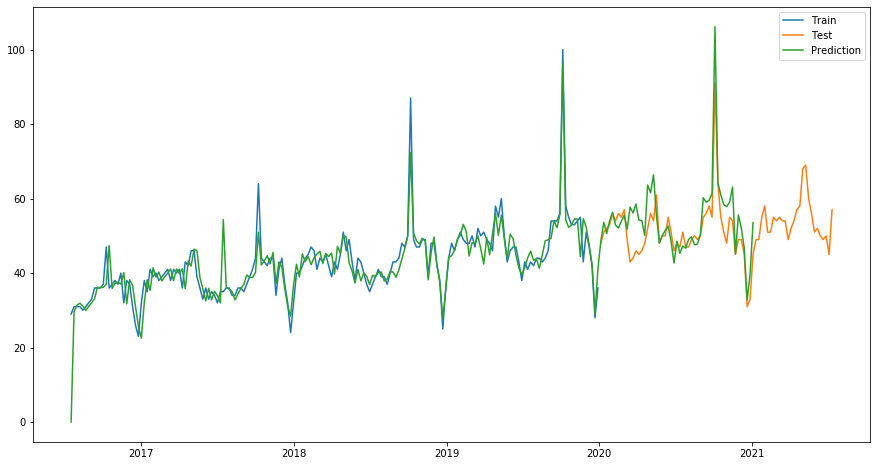

In [46]:
plt.figure(figsize = (15,8))
plt.plot(train, label = 'Train')    
plt.plot(test, label = 'Test')
plt.plot(pred, label = 'Prediction')
plt.legend(loc = 'best')
plt.show()

In [47]:
forecast = results.predict(start = '2021-08', end = '2023')

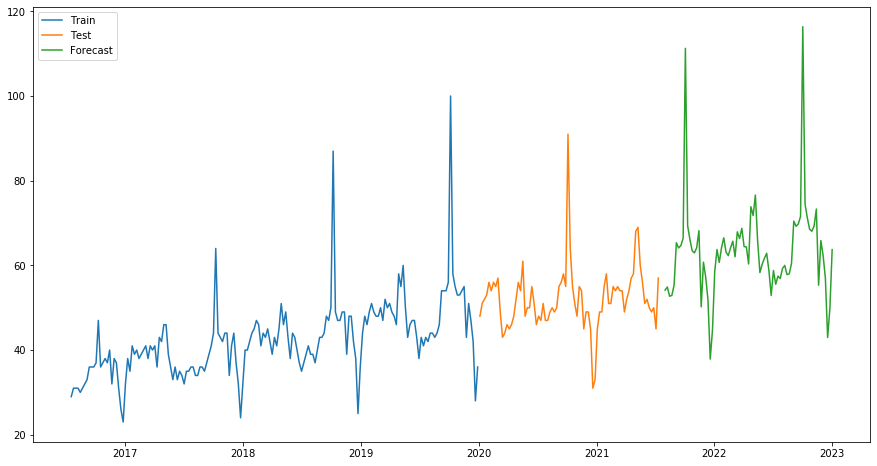

In [48]:
plt.figure(figsize = (15,8))
plt.plot(train, label = 'Train')    
plt.plot(test, label = 'Test')
plt.plot(forecast, label = 'Forecast')
plt.legend(loc = 'best')
plt.show()

## 5. Evaluate the model

In [49]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:         mental health: (Worldwide)   No. Observations:                  181
Model:             SARIMAX(3, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -199.726
Date:                            Wed, 08 Dec 2021   AIC                            411.452
Time:                                    11:40:21   BIC                            425.276
Sample:                                07-17-2016   HQIC                           416.966
                                     - 12-29-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0667      0.135      0.493      0.622      -0.198       0.332
ar.L2          0.0310      0.197      0.157      0.875      -0.356       0.418
ar.L3          0.0871      0.186      0.467      0.641      -0.278       0.453
ma.L1         -0.9921      0.048    -20.472      0.000      -1.087      -0.897
ma.S.L52       0.2792      0.102      2.744      0.006       0.080       0.479
sigma2        12.8476      1.749      7.347      0.000       9.420      16.275
===================================================================================
Ljung-Box (Q):                       28.16   Jarque-Bera (JB):                51.87
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                             0.64
Prob(H) (two-sided):                  0.50   Kurtosis:                         6.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

good models are obtained by minimising the AIC and BIC 